In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numba
import scipy.stats as stats
from dataclasses import dataclass

import warnings
warnings.filterwarnings('ignore')

from typing import List, Tuple

### Plotting Mean Curves

In [2]:
def percentile(n):
    @numba.jit(forceobj=True, fastmath=True)
    def _percentile(x):
        return np.percentile(x, n)
    return _percentile

def aggregate_simulations(stats: pd.DataFrame, expected_count: int):
    columns_to_aggregate = [
        'n_craters_in_observed_area',
        'areal_density',
        'z',
        'za'
    ]
    aggregations = {
        x: [
            'min',
            pd.NamedAgg(column=x, aggfunc=percentile(25)),
            'mean',
            pd.NamedAgg(column=x, aggfunc=percentile(75)),
            'max'
        ]
        for x in columns_to_aggregate
    }
    col_names = [
        [
            f'{x}_min',
            f'{x}_25_percentile',
            f'{x}_mean',
            f'{x}_75_percentile',
            f'{x}_max'
        ]
        for x in columns_to_aggregate
    ]
    col_names = [y for x in col_names for y in x]

    grouped = stats.groupby(['n_craters_added_in_observed_area']).agg(
        aggregations
    )

    grouped.columns = col_names
    grouped['group_count'] = stats.groupby(['n_craters_added_in_observed_area']).n_craters_in_observed_area.agg('count')
    
    # Make sure all samples have full data
    grouped = grouped[grouped.group_count == expected_count]
    grouped.reset_index(inplace=True)
    
    return grouped


def plot_statistics(stats: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot crater count
    ax = axes[0][0]
    ax.plot(stats.n_craters_added_in_observed_area, stats.n_craters_in_observed_area_min, label='Min')
    ax.plot(stats.n_craters_added_in_observed_area, stats.n_craters_in_observed_area_25_percentile, label='25th')
    ax.plot(stats.n_craters_added_in_observed_area, stats.n_craters_in_observed_area_mean, label='Mean')
    ax.plot(stats.n_craters_added_in_observed_area, stats.n_craters_in_observed_area_75_percentile, label='75th')
    ax.plot(stats.n_craters_added_in_observed_area, stats.n_craters_in_observed_area_max, label='Max')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Craters in Study Region')
    ax.legend(loc='upper left')

    # Plot crater count
    ax = axes[0][1]
    ax.plot(stats.n_craters_added_in_observed_area, stats.areal_density_min, label='Min')
    ax.plot(stats.n_craters_added_in_observed_area, stats.areal_density_25_percentile, label='25th')
    ax.plot(stats.n_craters_added_in_observed_area, stats.areal_density_mean, label='Mean')
    ax.plot(stats.n_craters_added_in_observed_area, stats.areal_density_75_percentile, label='75th')
    ax.plot(stats.n_craters_added_in_observed_area, stats.areal_density_max, label='Max')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Areal Density')

    # Plot Z statistic
    ax = axes[1][0]
    ax.plot(stats.n_craters_added_in_observed_area, stats.z_min, label='Min')
    ax.plot(stats.n_craters_added_in_observed_area, stats.z_25_percentile, label='25th')
    ax.plot(stats.n_craters_added_in_observed_area, stats.z_mean, label='Mean')
    ax.plot(stats.n_craters_added_in_observed_area, stats.z_75_percentile, label='75th')
    ax.plot(stats.n_craters_added_in_observed_area, stats.z_max, label='Max')
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Z Statistic')

    # Plot Za statistic
    ax = axes[1][1]
    ax.plot(stats.n_craters_added_in_observed_area, stats.za_min, label='Min')
    ax.plot(stats.n_craters_added_in_observed_area, stats.za_25_percentile, label='25th')
    ax.plot(stats.n_craters_added_in_observed_area, stats.za_mean, label='Mean')
    ax.plot(stats.n_craters_added_in_observed_area, stats.za_75_percentile, label='75th')
    ax.plot(stats.n_craters_added_in_observed_area, stats.za_max, label='Max')
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Za Statistic')

    plt.show()

def plot_four_metric_plots(python_stats: pd.DataFrame,
                           idl_stats: pd.DataFrame,
                           n_craters_column: str,
                           areal_density_column: str,
                           z_column: str,
                           za_column: str,
                           output_filename: str):
    fig, axes = plt.subplot_mosaic([['(a)', '(b)'], ['(c)', '(d)']],
                               figsize=(12, 7),
                               constrained_layout=True)

    for label, ax in axes.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='large',
                verticalalignment='top',
                fontfamily='serif',
                bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))

    # Plot crater count
    ax = axes['(a)']
    ax.plot(python_stats.n_craters_added_in_observed_area, python_stats[n_craters_column], color='b', label='Python')
    ax.plot(idl_stats.n_craters_added_in_observed_area, idl_stats[n_craters_column], color='r', label='IDL')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Craters in Study Region')
    ax.legend(loc='lower right')

    # Plot crater count
    ax = axes['(b)']
    ax.plot(python_stats.n_craters_added_in_observed_area, python_stats[areal_density_column], color='b', label='Python')
    ax.plot(idl_stats.n_craters_added_in_observed_area, idl_stats[areal_density_column], color='r', label='IDL')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Areal Density')

    # Plot Z statistic
    ax = axes['(c)']
    ax.plot(python_stats.n_craters_added_in_observed_area, python_stats[z_column], color='b', label='Python')
    ax.plot(idl_stats.n_craters_added_in_observed_area, idl_stats[z_column], color='r', label='IDL')
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Z Statistic')

    # Plot Za statistic
    ax = axes['(d)']
    ax.plot(python_stats.n_craters_added_in_observed_area, python_stats[za_column], color='b', label='Python')
    ax.plot(idl_stats.n_craters_added_in_observed_area, idl_stats[za_column], color='r', label='IDL')
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Za Statistic')

    plt.savefig(output_filename)
    plt.show()

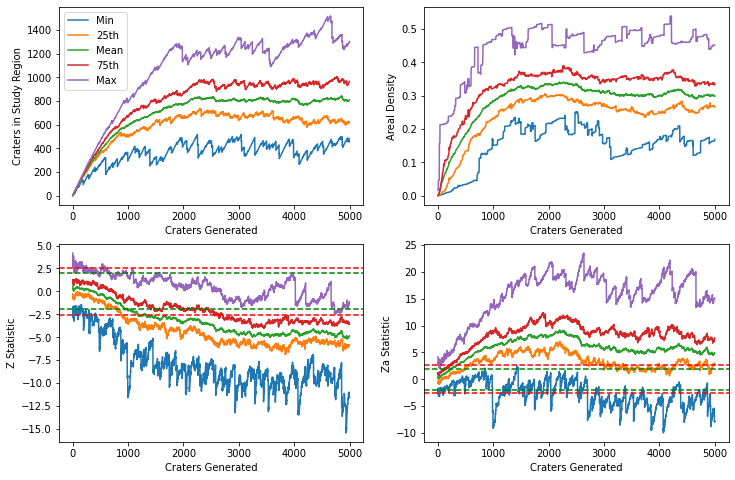

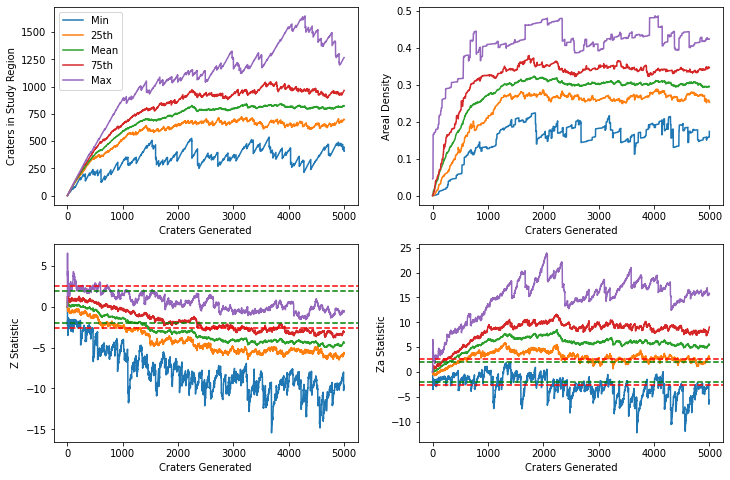

In [4]:
python_base_path = '/home/mason/full_runs/python'
idl_base_path = '/home/mason/full_runs/idl'
slope = 1.00
r_stat_multiplier = 3.00
min_rim_percentage = 0.40
effective_radius_multiplier = 1.50

filenames = [
    f'{python_base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/{x}/statistics.csv'
    for x in range(1, 56)
]

python_sim_stats = []
for index, filename in enumerate(filenames):
    stats = pd.read_csv(filename)
    stats['simulation_id'] = index
    python_sim_stats.append(stats)

python_stats_combined = pd.concat(python_sim_stats, axis=0).dropna()
python_stats_aggregated = aggregate_simulations(python_stats_combined, len(python_sim_stats))


filenames = [
    f'{idl_base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/run_{-slope:.2f}_{effective_radius_multiplier:.2f}_{min_rim_percentage:.2f}_{r_stat_multiplier:.2f}_{x}_1.csv'
    for x in range(1, 56)
]

idl_sim_stats = []
for index, filename in enumerate(filenames):
    stats = pd.read_csv(filename, skiprows=1)
    stats.columns = ['n_craters_added_in_observed_area', 'n_craters_in_observed_area', 'areal_density', 'z', 'za']
    stats.areal_density = stats.areal_density / 10000**2
    stats['simulation_id'] = index
    idl_sim_stats.append(stats)

idl_stats_combined = pd.concat(idl_sim_stats, axis=0).dropna()
idl_stats_aggregated = aggregate_simulations(idl_stats_combined, len(idl_sim_stats))

plot_statistics(python_stats_aggregated)
plot_statistics(idl_stats_aggregated)

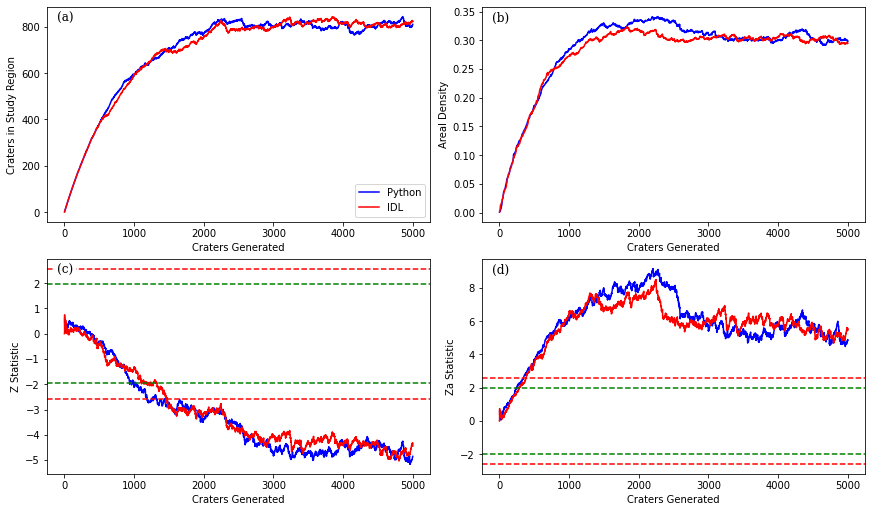

In [5]:
plot_four_metric_plots(python_stats_aggregated,
                       idl_stats_aggregated,
                       'n_craters_in_observed_area_mean',
                       'areal_density_mean',
                       'z_mean',
                       'za_mean',
                       f'figures/mean_curves_{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}.png')

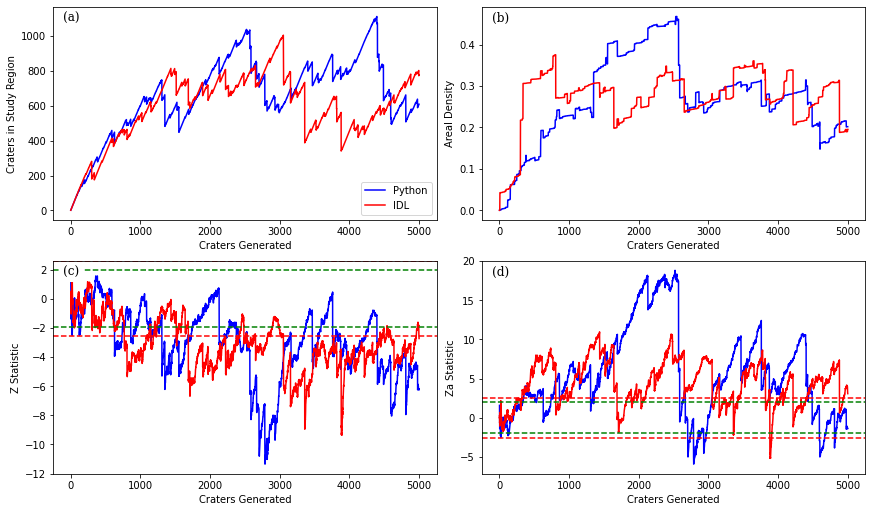

In [6]:
plot_four_metric_plots(python_stats_combined[python_stats_combined.simulation_id == 0],
                       idl_stats_combined[idl_stats_combined.simulation_id == 0],
                       'n_craters_in_observed_area',
                       'areal_density',
                       'z',
                       'za',
                       f'figures/single_sim_curves_{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}.png')

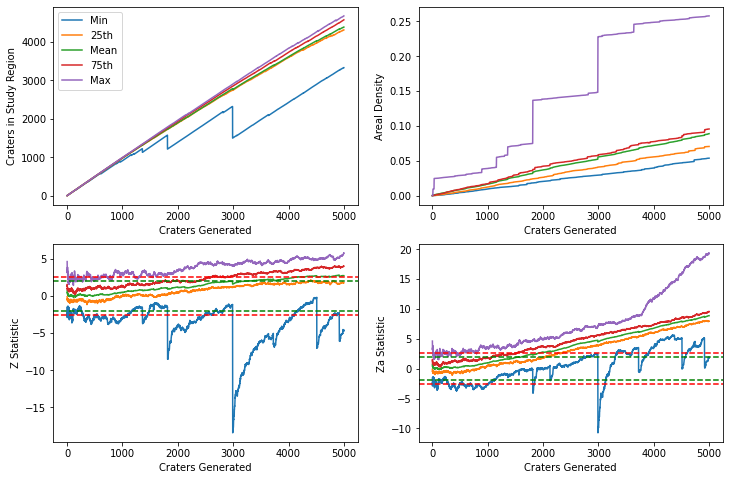

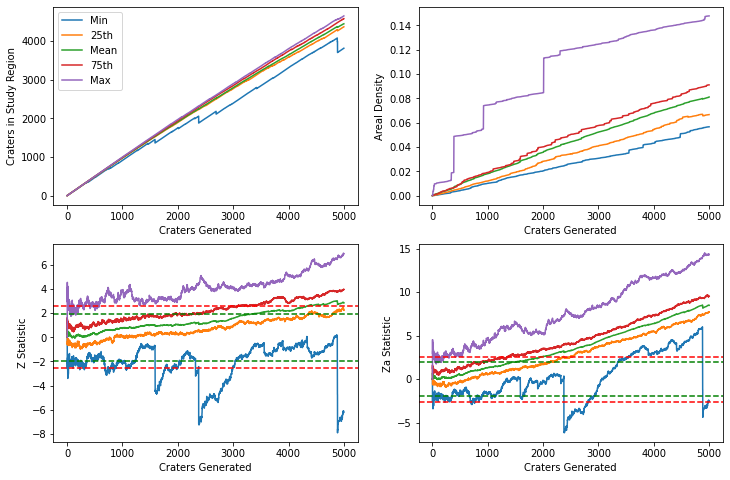

In [7]:
# Another configuration
python_base_path = '/home/mason/full_runs/python'
idl_base_path = '/home/mason/full_runs/idl'
slope = 2.00
r_stat_multiplier = 3.00
min_rim_percentage = 0.40
effective_radius_multiplier = 1.70

filenames = [
    f'{python_base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/{x}/statistics.csv'
    for x in range(1, 56)
]

sim_stats = []
for index, filename in enumerate(filenames):
    stats = pd.read_csv(filename)
    stats['simulation_id'] = index
    sim_stats.append(stats)

stats = pd.concat(sim_stats, axis=0).dropna()
python_stats = aggregate_simulations(stats, len(sim_stats))


filenames = [
    f'{idl_base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/run_{-slope:.2f}_{effective_radius_multiplier:.2f}_{min_rim_percentage:.2f}_{r_stat_multiplier:.2f}_{x}_1.csv'
    for x in range(1, 56)
]

sim_stats = []
for index, filename in enumerate(filenames):
    stats = pd.read_csv(filename, skiprows=1)
    stats.columns = ['n_craters_added_in_observed_area', 'n_craters_in_observed_area', 'areal_density', 'z', 'za']
    stats.areal_density = stats.areal_density / 10000**2
    stats['simulation_id'] = index
    sim_stats.append(stats)

stats = pd.concat(sim_stats, axis=0).dropna()
idl_stats = aggregate_simulations(stats, len(sim_stats))

plot_statistics(python_stats)
plot_statistics(idl_stats)

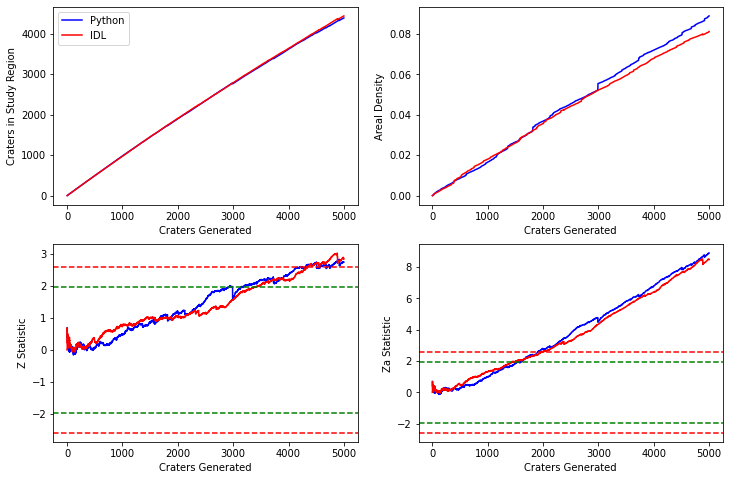

In [8]:
# Plot just mean curves
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot crater count
ax = axes[0][0]
ax.plot(python_stats.n_craters_added_in_observed_area, python_stats.n_craters_in_observed_area_mean, color='b', label='Python')
ax.plot(idl_stats.n_craters_added_in_observed_area, idl_stats.n_craters_in_observed_area_mean, color='r', label='IDL')
ax.set_xlabel('Craters Generated')
ax.set_ylabel('Craters in Study Region')
ax.legend(loc='upper left')

# Plot crater count
ax = axes[0][1]
ax.plot(python_stats.n_craters_added_in_observed_area, python_stats.areal_density_mean, color='b', label='Python')
ax.plot(idl_stats.n_craters_added_in_observed_area, idl_stats.areal_density_mean, color='r', label='IDL')
ax.set_xlabel('Craters Generated')
ax.set_ylabel('Areal Density')

# Plot Z statistic
ax = axes[1][0]
ax.plot(python_stats.n_craters_added_in_observed_area, python_stats.z_mean, color='b', label='Python')
ax.plot(idl_stats.n_craters_added_in_observed_area, idl_stats.z_mean, color='r', label='IDL')
ax.axhline(-1.96, color='g', ls='--')
ax.axhline(1.96, color='g', ls='--')
ax.axhline(-2.58, color='r', ls='--')
ax.axhline(2.58, color='r', ls='--')
ax.set_xlabel('Craters Generated')
ax.set_ylabel('Z Statistic')

# Plot Za statistic
ax = axes[1][1]
ax.plot(python_stats.n_craters_added_in_observed_area, python_stats.za_mean, color='b', label='Python')
ax.plot(idl_stats.n_craters_added_in_observed_area, idl_stats.za_mean, color='r', label='IDL')
ax.axhline(-1.96, color='g', ls='--')
ax.axhline(1.96, color='g', ls='--')
ax.axhline(-2.58, color='r', ls='--')
ax.axhline(2.58, color='r', ls='--')
ax.set_xlabel('Craters Generated')
ax.set_ylabel('Za Statistic')

plt.show()

### Comparing mean curves using bootstrapping and KS/AD tests

In [9]:
def read_idl_stats(sim_number: int,
                   base_path: str,
                   slope: float,
                   r_stat_multiplier: float,
                   min_rim_percentage: float,
                   effective_radius_multiplier: float) -> pd.DataFrame:
    filename = f'{base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/run_{-slope:.2f}_{effective_radius_multiplier:.2f}_{min_rim_percentage:.2f}_{r_stat_multiplier:.2f}_{sim_number}_1.csv'
    
    stats = pd.read_csv(filename, skiprows=1)
    stats.columns = ['n_craters_added_in_observed_area', 'n_craters_in_observed_area', 'areal_density', 'z', 'za']
    stats.areal_density = stats.areal_density / 10000**2

    return stats

def read_python_stats(sim_number: int,
                      base_path: str,
                      slope: float,
                      r_stat_multiplier: float,
                      min_rim_percentage: float,
                      effective_radius_multiplier: float) -> pd.DataFrame:
    filename = f'{base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/{sim_number}/statistics.csv'
    
    stats = pd.read_csv(filename)
    stats.columns = ['crater_id', 'n_craters_added_in_observed_area', 'n_craters_in_observed_area', 'areal_density', 'z', 'za']

    return stats

In [10]:
@dataclass
class BootstrapResult:
    mean: float
    lower: float
    upper: float
    critical_value: float

def bootstrap_ks_statistic(first_sets: List[pd.DataFrame],
                           second_sets: List[pd.DataFrame],
                           metric: str,
                           n_resamples: int,
                           alpha: float = 0.05) -> BootstrapResult:
    """
    Assumes an equal number of sets in first_sets and second_sets, and an equal number of samples in all sets.
    """
    # Combine sets into a single set
    first_sets = [x[metric] for x in first_sets]
    second_sets = [x[metric] for x in second_sets]
    sets = first_sets + second_sets
    
    n_samples = len(sets[0])
    n_sets = len(sets)
        
    statistics = []
    for x in range(n_resamples):
        # Grab two sets, could be from A or B
        choice1 = sets[int(np.random.rand() * n_sets)]
        choice2 = sets[int(np.random.rand() * n_sets)]

        statistics.append(stats.kstest(choice1, choice2).statistic)
        
    mean = np.mean(statistics)
    lower = np.quantile(statistics, alpha / 2)
    upper = np.quantile(statistics, 1 - alpha / 2)
    critical_value = np.sqrt(-np.log(alpha/2)*(1/n_samples))
    return BootstrapResult(
        mean=mean,
        lower=lower,
        upper=upper,
        critical_value=critical_value
    )

def bootstrap_ad_statistic(first_sets: List[pd.DataFrame],
                           second_sets: List[pd.DataFrame],
                           metric: str,
                           n_resamples: int) -> BootstrapResult:
    """
    Assumes an equal number of sets in first_sets and second_sets, and an equal number of samples in all sets.
    Assumes an alpha of 0.05, leading to a critical value of 1.226
    """
    alpha = 0.05
    
    # Combine sets into a single set
    first_sets = [x[metric] for x in first_sets]
    second_sets = [x[metric] for x in second_sets]
    sets = first_sets + second_sets
    
    n_samples = len(sets[0])
    n_sets = len(sets)
        
    statistics = []
    for x in range(n_resamples):
        # Grab two sets, could be from A or B
        choice1 = sets[int(np.random.rand() * n_sets)]
        choice2 = sets[int(np.random.rand() * n_sets)]

        statistics.append(stats.anderson_ksamp([choice1, choice2]).statistic)
        
    mean = np.mean(statistics)
    lower = np.quantile(statistics, alpha / 2)
    upper = np.quantile(statistics, 1 - alpha / 2)   
    return BootstrapResult(
        mean=mean,
        lower=lower,
        upper=upper,
        critical_value=1.226
    )

def test_metric(first_sets: List[pd.DataFrame],
                second_sets: List[pd.DataFrame],
                metric: str,
                n_resamples: int,
                alpha: float = 0.05):
    result = bootstrap_ks_statistic(first_sets, second_sets, metric, n_resamples)
    print(f"{metric} KS results:")
    print(f"    mean={result.mean:.3f}")
    print(f"    lower={result.lower:.3f}")
    print(f"    upper={result.upper:.3f}")
    print(f"    critical value={result.critical_value:.3f}")
    if result.mean > result.critical_value:
        print(f"    conclusion: reject H0, distributions are not equal")
    else:
        print(f"    conclusion: fail to reject H0, distributions are equal")
    
    result = bootstrap_ad_statistic(second_sets, second_sets, metric, n_resamples)
    print(f"{metric} AD results:")
    print(f"    mean={result.mean:.3f}")
    print(f"    lower={result.lower:.3f}")
    print(f"    upper={result.upper:.3f}")
    print(f"    critical value={result.critical_value:.3f}")
    if result.mean > result.critical_value:
        print(f"    conclusion: reject H0, distributions are not equal")
    else:
        print(f"    conclusion: fail to reject H0, distributions are equal")

In [13]:
python_base_path = f'/home/mason/full_runs/python/'
idl_base_path = f'/home/mason/full_runs/idl/'

slope = 1.00
r_stat_multiplier = 3.00
min_rim_percentage = 0.40
effective_radius_multiplier = 1.50
n_sims = 55

idl_stats = [
    read_idl_stats(x,
                   idl_base_path,
                   slope,
                   r_stat_multiplier,
                   min_rim_percentage,
                   effective_radius_multiplier)
    for x in range(1, n_sims+1)
]

python_stats = [
    read_python_stats(x,
                      python_base_path,
                      slope,
                      r_stat_multiplier,
                      min_rim_percentage,
                      effective_radius_multiplier)
    for x in range(1, n_sims+1)
]

metrics = ['n_craters_in_observed_area', 'areal_density', 'z', 'za']
for metric in metrics:
    test_metric(idl_stats, python_stats, metric, 10000)

n_craters_in_observed_area KS results:
    mean=0.273
    lower=0.075
    upper=0.567
    critical value=0.027
    conclusion: reject H0, distributions are not equal
n_craters_in_observed_area AD results:
    mean=567.560
    lower=22.866
    upper=1863.866
    critical value=1.226
    conclusion: reject H0, distributions are not equal
areal_density KS results:
    mean=0.294
    lower=0.103
    upper=0.597
    critical value=0.027
    conclusion: reject H0, distributions are not equal
areal_density AD results:
    mean=630.283
    lower=34.124
    upper=2155.966
    critical value=1.226
    conclusion: reject H0, distributions are not equal
z KS results:
    mean=0.160
    lower=0.056
    upper=0.318
    critical value=0.027
    conclusion: reject H0, distributions are not equal
z AD results:
    mean=150.074
    lower=12.833
    upper=490.702
    critical value=1.226
    conclusion: reject H0, distributions are not equal
za KS results:
    mean=0.228
    lower=0.070
    upper=0.467
 

In [14]:
python_base_path = f'/home/mason/full_runs/python/'
idl_base_path = f'/home/mason/full_runs/idl/'

slope = 2.00
r_stat_multiplier = 3.00
min_rim_percentage = 0.40
effective_radius_multiplier = 1.70
n_sims = 55

idl_stats = [
    read_idl_stats(x,
                   idl_base_path,
                   slope,
                   r_stat_multiplier,
                   min_rim_percentage,
                   effective_radius_multiplier)
    for x in range(1, n_sims+1)
]

python_stats = [
    read_python_stats(x,
                      python_base_path,
                      slope,
                      r_stat_multiplier,
                      min_rim_percentage,
                      effective_radius_multiplier)
    for x in range(1, n_sims+1)
]

metrics = ['n_craters_in_observed_area', 'areal_density', 'z', 'za']
for metric in metrics:
    test_metric(idl_stats, python_stats, metric, 10000)

n_craters_in_observed_area KS results:
    mean=0.055
    lower=0.012
    upper=0.158
    critical value=0.027
    conclusion: reject H0, distributions are not equal
n_craters_in_observed_area AD results:
    mean=46.752
    lower=-0.754
    upper=470.896
    critical value=1.226
    conclusion: reject H0, distributions are not equal
areal_density KS results:
    mean=0.301
    lower=0.093
    upper=0.682
    critical value=0.027
    conclusion: reject H0, distributions are not equal
areal_density AD results:
    mean=601.856
    lower=13.515
    upper=2035.017
    critical value=1.226
    conclusion: reject H0, distributions are not equal
z KS results:
    mean=0.356
    lower=0.110
    upper=0.704
    critical value=0.027
    conclusion: reject H0, distributions are not equal
z AD results:
    mean=919.553
    lower=54.447
    upper=3110.371
    critical value=1.226
    conclusion: reject H0, distributions are not equal
za KS results:
    mean=0.251
    lower=0.102
    upper=0.463
  

### Comparing SFDs using boostrapped CIs on KS and AD statistics

The final SFDs of all Python simulations are compared against those of all IDL simulations. For each pair (Python sim, IDL sim), KS and AD statistics are computed. A 95% confidence interval is bootstrapped from the resulting KS and AD statistics.

In [15]:
def read_idl_radii(sim_number: int,
                   base_path: str,
                   slope: float,
                   r_stat_multiplier: float,
                   min_rim_percentage: float,
                   effective_radius_multiplier: float) -> pd.DataFrame:
    filename = f'{base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/run_-{slope:.2f}_{effective_radius_multiplier:.2f}_{min_rim_percentage:.2f}_{r_stat_multiplier:.2f}_{sim_number}_3.csv'
    
    data = pd.read_csv(filename, skiprows=3, header=None)
    data.columns = ['x', 'y', 'radius', 'order_removed']
    radii = data[data.order_removed == 0]

    return radii

def read_python_radii(sim_number: int,
                      base_path: str,
                      slope: float,
                      r_stat_multiplier: float,
                      min_rim_percentage: float,
                      effective_radius_multiplier: float,
                      step_number: int = 5000) -> pd.DataFrame:
    filename = f'{base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/{sim_number}/state_{step_number}.csv'
    
    radii = pd.read_csv(filename)
    return radii

In [16]:
slope = 1.00
r_stat_multiplier = 3.00
min_rim_percentage = 0.40
effective_radius_multiplier = 1.50
n_sims = 55

idl_radii = [
    read_idl_radii(x,
                   idl_base_path,
                   slope,
                   r_stat_multiplier,
                   min_rim_percentage,
                   effective_radius_multiplier)
    for x in range(1, n_sims+1)
]

python_radii = [
    read_python_radii(x,
                      python_base_path,
                      slope,
                      r_stat_multiplier,
                      min_rim_percentage,
                      effective_radius_multiplier,
                      4999)
    for x in range(1, n_sims+1)
]
test_metric(idl_radii, python_radii, "radius", 10000)

radius KS results:
    mean=0.045
    lower=0.023
    upper=0.083
    critical value=0.069
    conclusion: fail to reject H0, distributions are equal
radius AD results:
    mean=0.055
    lower=-1.046
    upper=2.712
    critical value=1.226
    conclusion: fail to reject H0, distributions are equal
